In [1]:
import os
import gc
import re
import time
import random
import numpy as np
import csv
import copy
import glob
import math
import joblib
import torch
import torch.nn as nn
from torch.optim import AdamW
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
from transformers import BertTokenizer, VisualBertForQuestionAnswering, VisualBertConfig
import scipy
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from scipy.interpolate import CubicSpline, interp1d
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, classification_report, top_k_accuracy_score
from captum.attr import LayerIntegratedGradients
from captum.attr._utils.input_layer_wrapper import ModelInputWrapper
import warnings
warnings.filterwarnings("ignore")

def scherrer_fwhm(crystal_size, theta, wavelength=1.5406, shape_factor=0.9):
    theta_rad = np.deg2rad(theta/2)
    fwhm = (shape_factor*wavelength)/(crystal_size*np.cos(theta_rad))
    return fwhm

def predict(XRD, text):
    
    inputs = {"input_ids":text.to('cuda'), 
              "token_type_ids":torch.zeros(text.shape, dtype=torch.long).to('cuda'), 
              "attention_mask":torch.ones(text.shape, dtype=torch.long).to('cuda'),
              "visual_embeds": XRD.to('cuda'),
              "visual_token_type_ids": torch.ones(XRD.shape[:-1], dtype=torch.long).to('cuda'),
              "visual_attention_mask": torch.ones(XRD.shape[:-1], dtype=torch.long).to('cuda'),}
    output = model_wrapped(**inputs)
    
    return output.logits

def load_plt_setting():
    plt.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['text.usetex'] = False

translate_dic = {'alpha':r'$\alpha$','beta':r'$\beta$','delta':r'$\delta$','gamma':r'$\gamma$','Pnma':r'orthorhombic'}

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
_ = tokenizer.add_tokens('pb')

# 1 Dataloader

In [2]:
class DataLoader():
    '''
    [Input]
    dataset_path:      Path to dataset generated from preprocess.py
                       dataset: 'formula', 'element_list', 'space_group', 'xrd_list'
                                'xrd_list': list of (X,Y), len(xrd_list) depends on the strain setting
    
    batch_size:        Batch size n.
    n_mix:             List of n compounds coexisting in one XRD.
    
    [Output]
    Xs:                Array of intensity in (n,Y,1), n = batch_size
    Ys:                Array of classification labels in (n, len(dataset))
    element_list:      List of elements for each sample, n = len(element_list) 
    formula_list:      Human labels, n = len(formula_list)
    '''
    def __init__(self, dataset_path):
        
        try:
            with open(dataset_path, 'rb') as handle:
                self.dataset = joblib.load(handle)
                print('Loading dataset successful.')
        except:
            print("Missing dataset.")
        
        self.sample_list, self.sample_formula_list, self.combination_list = [], [], []
        self.multiphase = {}
        self.len = len(self.dataset)
        
        for sample, self.data in self.dataset.items():
            self.sample_list.append(sample)
            formula = self.data['formula']
            if '-' in formula:
                formula = formula.split('-')
                formula = formula[-1] + '-' + formula[0]
            self.sample_formula_list.append(re.findall(r'\D+', formula) + re.findall(r'\d+', formula))
            
        self.sample_list = [x for _, x in sorted(zip(self.sample_formula_list, self.sample_list))]
        for i,sample in enumerate(self.sample_list):
            self.elements = self.dataset[sample]['element_list']
            self.multiphase[''.join(set(self.elements))] = {'elements':self.elements,'samples':[]}
            print(i,self.dataset[sample]['formula'],self.elements)
            
        for sample in self.sample_list:
            self.elements = self.dataset[sample]['element_list']
            for combination in self.multiphase.keys():
                if set(self.elements).issubset(set(self.multiphase[combination]['elements'])):
                    self.multiphase[combination]['samples'].append(sample)    
        
        self.multiphase = {k: v for k, v in self.multiphase.items() if len(v.get('samples', [])) >= 2}
        print('\n{} chemical spaces created:'.format(len(self.multiphase)))
        print(self.multiphase)
        
    def load_data(self, batch_size=10, twotheta=np.arange(5.00, 60.01, 0.01), 
                  n_mix=[1,2,3], resonable_mixing=False, min_mixing_ratio=0.05, 
                  high_orientation_probability=0.2, crystal_size_range=(5, 20), intensity_variation_range=(0.2, 1), 
                  noise_sigma_list=np.logspace(-4,-2,num=101)):
        
        self.n_mix_list = np.random.choice(n_mix, batch_size, replace=True)
        
        self.Xs = np.zeros((batch_size,len(twotheta),1))
        self.Ys = np.zeros((batch_size,self.len))
        self.element_list, self.formula_list = [], []
        
        i = 0
        while i < batch_size:
            if resonable_mixing and self.n_mix_list[i]!=1:
                self.sample_idxs = []
                samples = []
                while len(samples) < self.n_mix_list[i]:
                    samples = self.multiphase[np.random.choice(list(self.multiphase.keys()))]['samples']
                self.n_mix_list[i] = min(self.n_mix_list[i],len(samples))
                samples = np.random.choice(samples, self.n_mix_list[i], replace=False)
                for sample in samples:
                    self.sample_idxs.append(self.sample_list.index(sample))
            else:
                self.sample_idxs = np.random.choice(self.len, size=self.n_mix_list[i], replace=False)
            self.formulas, self.elements = [], []
            
            self.mixing_ratio = np.random.uniform(min_mixing_ratio,1,len(self.sample_idxs))
            self.mixing_ratio = self.mixing_ratio/np.sum(self.mixing_ratio)
            
            for j, sample_idx in enumerate(self.sample_idxs):
                self.data = self.dataset[self.sample_list[sample_idx]]
                self.formulas.append(self.data['formula'])
                for element in self.data['element_list']:
                    if element not in self.elements:
                        self.elements.append(element)
                self.Ys[i, sample_idx] += 1
                
                self.twotheta_short, self.X_short = self.data['xrd_list'][np.random.randint(0,len(self.data['xrd_list']))]
                if np.random.binomial(1, high_orientation_probability) == 1:
                    high_orientation_peak_index = np.random.choice(np.argpartition(dataloader.X_short,-3)[-3:],1)[0]
                    self.X_short = np.array([self.X_short[high_orientation_peak_index]])
                    self.twotheta_short = np.array([self.twotheta_short[high_orientation_peak_index]])
                
                self.X = np.zeros(twotheta.shape)
                self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
                
                # Intensity variation
                self.X = self.X * np.random.uniform(*intensity_variation_range, self.X.shape[0])
                # Crystal size broadening
                fwhm = scherrer_fwhm(np.random.uniform(*crystal_size_range), twotheta)
                sigma = np.mean(fwhm)/(2*np.sqrt(2*np.log(2)))
                self.X = gaussian_filter(self.X, sigma=sigma*100)
                
                self.Xs[i,:,0] += self.X/np.max(self.X)*self.mixing_ratio[j]
            
            if np.max(self.Xs[i,:,0]) == 0:
                self.Ys[i, :] = np.zeros(self.Ys[i, :].shape)
                pass
            else:
                self.Xs[i,:,0] = self.Xs[i,:,0]/np.max(self.Xs[i,:,0]) + np.random.normal(0, np.random.choice(noise_sigma_list), len(twotheta))
                self.Xs[i,:,0] = (self.Xs[i,:,0]-np.min(self.Xs[i,:,0]))/(np.max(self.Xs[i,:,0])-np.min(self.Xs[i,:,0]))
                self.formula_list.append(self.formulas)
                self.element_list.append(list(set(np.array(self.elements).flatten())))
                i += 1
            
        return self.Xs, self.Ys, self.element_list, self.formula_list, self.n_mix_list
    
    def load_ref(self, sample_idx=0, twotheta=np.arange(5.00, 60.01, 0.01),):
        
        self.data = self.dataset[self.sample_list[sample_idx]]
        self.twotheta_short, self.X_short = self.data['xrd_list'][int(len(dataloader.data['xrd_list'])/2+0.5)]
        self.X = np.zeros(twotheta.shape)
        self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
        self.X = self.X/np.max(self.X)
        return self.X

In [3]:
folder = os.getcwd()
cif_folder = os.path.join(folder, 'cif')
dataloader = DataLoader(os.path.join(cif_folder, 'dataset.npy'))

Loading dataset successful.
0 Cs0.2FA0.8PbBr3 ['Cs', 'FA', 'Pb', 'Br']
1 Cs0.4FA0.6PbBr3 ['Cs', 'FA', 'Pb', 'Br']
2 Cs0.6FA0.4PbBr3 ['Cs', 'FA', 'Pb', 'Br']
3 Cs0.8FA0.2PbBr3 ['Cs', 'FA', 'Pb', 'Br']
4 Cs0.2FA0.8PbI3 ['Cs', 'FA', 'Pb', 'I']
5 Cs0.4FA0.6PbI3 ['Cs', 'FA', 'Pb', 'I']
6 Cs0.6FA0.4PbI3 ['Cs', 'FA', 'Pb', 'I']
7 Cs0.8FA0.2PbI3 ['Cs', 'FA', 'Pb', 'I']
8 Cs0.2MA0.8PbBr3 ['Cs', 'MA', 'Pb', 'Br']
9 Cs0.4MA0.6PbBr3 ['Cs', 'MA', 'Pb', 'Br']
10 Cs0.6MA0.4PbBr3 ['Cs', 'MA', 'Pb', 'Br']
11 Cs0.8MA0.2PbBr3 ['Cs', 'MA', 'Pb', 'Br']
12 Cs0.2MA0.8PbI3 ['Cs', 'MA', 'Pb', 'I']
13 Cs0.4MA0.6PbI3 ['Cs', 'MA', 'Pb', 'I']
14 Cs0.6MA0.4PbI3 ['Cs', 'MA', 'Pb', 'I']
15 Cs0.8MA0.2PbI3 ['Cs', 'MA', 'Pb', 'I']
16 Cs4PbBr6 ['Cs', 'Pb', 'Br']
17 CsBr ['Cs', 'Br']
18 CsI ['Cs', 'I']
19 CsPb2Br5 ['Cs', 'Pb', 'Br']
20 CsPb(Cl0.2Br0.8)3 ['Cs', 'Pb', 'Br', 'Cl']
21 CsPb(Cl0.4Br0.6)3 ['Cs', 'Pb', 'Br', 'Cl']
22 CsPb(Cl0.6Br0.4)3 ['Cs', 'Pb', 'Br', 'Cl']
23 CsPb(Cl0.8Br0.2)3 ['Cs', 'Pb', 'Br', 'Cl']
24 CsPb(

# 2 Dataset t-SNE

[]

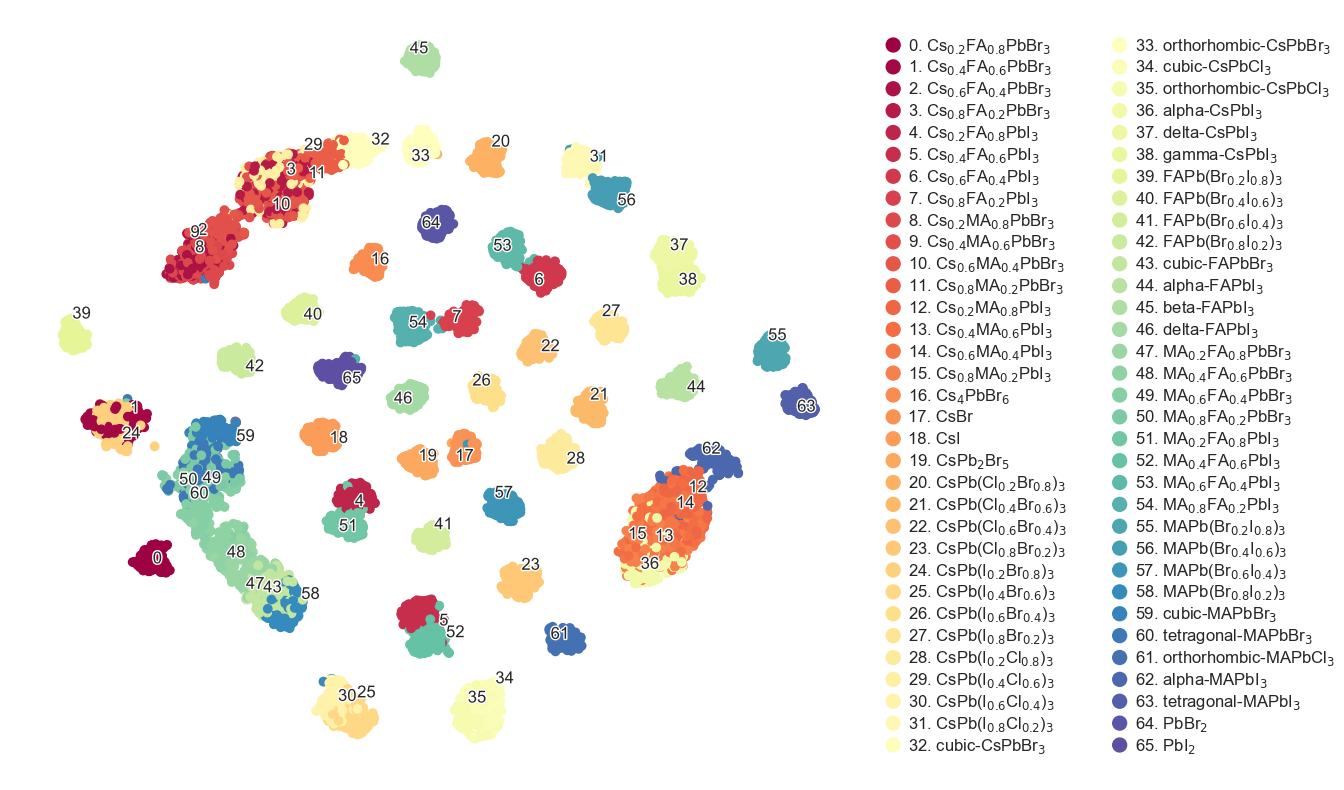

In [4]:
# from training, w/o orientation
Xs, Ys, element_list, formula_list, _ = dataloader.load_data(batch_size=10000, n_mix=[1],
                                                      high_orientation_probability=0, crystal_size_range=(5, 20), 
                                                      intensity_variation_range=(0.01, 1))
Xs = Xs[:,:-1,0]
Ys_int = [np.where(x==1)[0][0] for x in Ys]

tsne = TSNE(n_components=2, perplexity=40, random_state=0)
Xs_tsne = tsne.fit_transform(Xs)

Xs_tsne = (Xs_tsne-np.min(Xs_tsne))/(np.max(Xs_tsne)-np.min(Xs_tsne))

load_plt_setting()

fig, ax = plt.subplots(figsize=(15, 10))

cmap = mpl.cm.get_cmap('Spectral')
ax.scatter(Xs_tsne[:,0], Xs_tsne[:,1], c=cmap(Ys_int/np.max(Ys_int)))

for phase_id in range(66):
    i = Ys_int.index(phase_id)
    plt.text(Xs_tsne[i,0], Xs_tsne[i,1], '{}'.format(phase_id), fontsize=12, 
             path_effects=[pe.withStroke(linewidth=2, foreground='white')])
    
text_y = np.linspace(1,0,33)
x_shift = -0.03
ax.scatter(np.linspace(1.13,1.13,33)+x_shift, text_y, c=cmap(np.linspace(0,1,66)[:33]), s=100)
ax.scatter(np.linspace(1.43,1.43,33)+x_shift, text_y, c=cmap(np.linspace(0,1,66)[33:]), s=100)

y_shift = -0.008
for i, sample in enumerate(dataloader.sample_list):
    if i < 33:
        plt.text(1.15+x_shift, text_y[i]+y_shift, '{}. {}'.format(i,re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', dataloader.dataset[sample]['formula'])), fontsize=12)
    else:
        plt.text(1.45+x_shift, text_y[i-33]+y_shift, '{}. {}'.format(i,re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', dataloader.dataset[sample]['formula'])), fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

[]

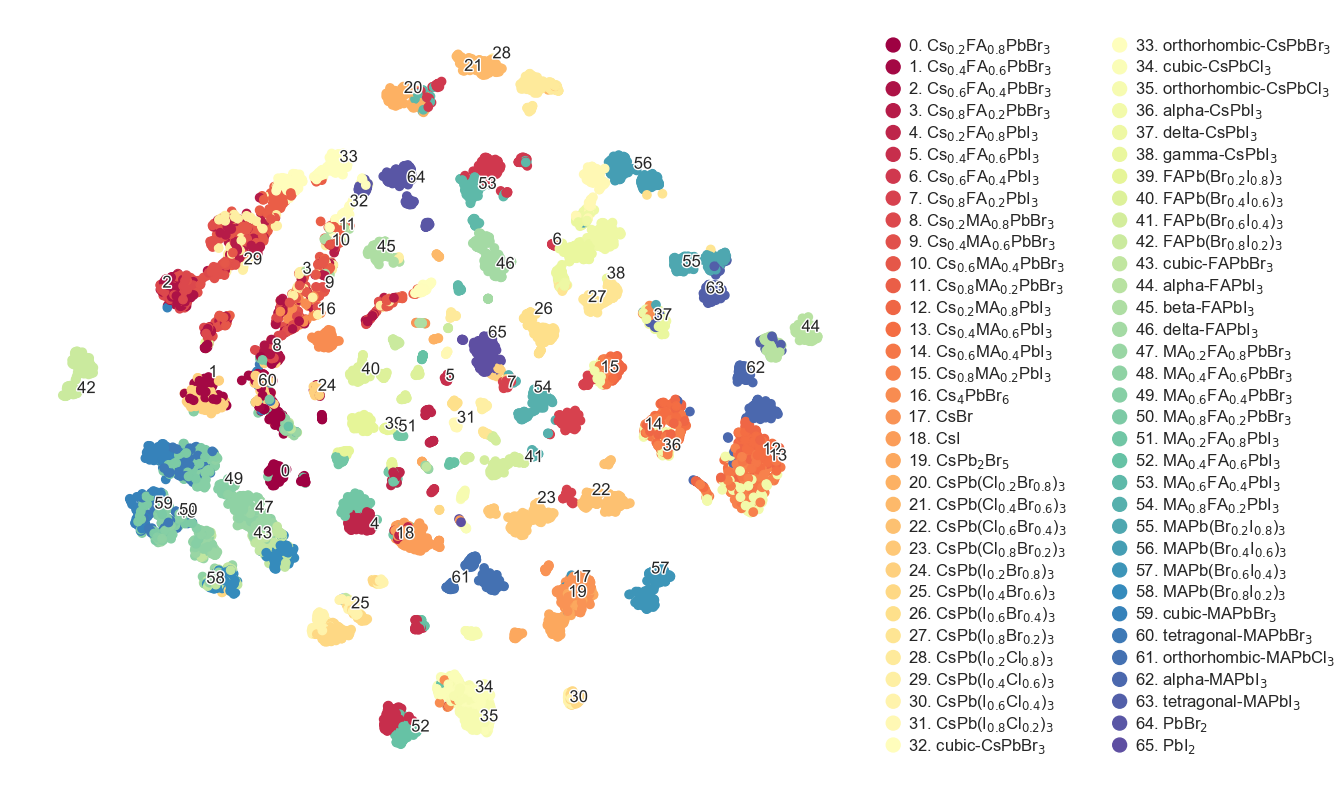

In [5]:
# w orientation
Xs, Ys, element_list, formula_list, _ = dataloader.load_data(batch_size=10000, n_mix=[1],
                                                      high_orientation_probability=0.5, crystal_size_range=(5, 20), 
                                                      intensity_variation_range=(0.01, 1))
Xs = Xs[:,:-1,0]
Ys_int = [np.where(x==1)[0][0] for x in Ys]

tsne = TSNE(n_components=2, perplexity=40, random_state=0)
Xs_tsne = tsne.fit_transform(Xs)

Xs_tsne = (Xs_tsne-np.min(Xs_tsne))/(np.max(Xs_tsne)-np.min(Xs_tsne))

load_plt_setting()

fig, ax = plt.subplots(figsize=(15, 10))

cmap = mpl.cm.get_cmap('Spectral')
ax.scatter(Xs_tsne[:,0], Xs_tsne[:,1], c=cmap(Ys_int/np.max(Ys_int)))

for phase_id in range(66):
    i = Ys_int.index(phase_id)
    plt.text(Xs_tsne[i,0], Xs_tsne[i,1], '{}'.format(phase_id), fontsize=12, 
             path_effects=[pe.withStroke(linewidth=2, foreground='white')])
    
text_y = np.linspace(1,0,33)
x_shift = -0.03
ax.scatter(np.linspace(1.13,1.13,33)+x_shift, text_y, c=cmap(np.linspace(0,1,66)[:33]), s=100)
ax.scatter(np.linspace(1.43,1.43,33)+x_shift, text_y, c=cmap(np.linspace(0,1,66)[33:]), s=100)

y_shift = -0.008
for i, sample in enumerate(dataloader.sample_list):
    if i < 33:
        plt.text(1.15+x_shift, text_y[i]+y_shift, '{}. {}'.format(i,re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', dataloader.dataset[sample]['formula'])), fontsize=12)
    else:
        plt.text(1.45+x_shift, text_y[i-33]+y_shift, '{}. {}'.format(i,re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', dataloader.dataset[sample]['formula'])), fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

# 3 Model interpretation

In [4]:
cif_folder = os.path.join(folder, 'cif')
sample_size = 3e7
visual_embedding_dim = 50
try:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'model', 'single_phase','{}'.format(int(sample_size)))).to('cuda')
    print('Loading trained model.')
except:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'pretrained_model', 'single_phase_early_fusion')).to('cuda')
    print('Loading pretrained model from repository.')
    
model_wrapped = ModelInputWrapper(model).to('cuda')
lig = LayerIntegratedGradients(predict, [model_wrapped.module.visual_bert.embeddings])

Loading pretrained model from repository.


In [5]:
with open(os.path.join(cif_folder, 'test_dataset_1phase.npy'), 'rb') as handle:
    test_dataset = joblib.load(handle)
Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
Ys_int = [np.where(x==1)[0][0] for x in Ys]

prompt_type = 'full'

for j in range(Ys.shape[1]):
    i = np.where(Ys[:,j]==1)[0][0]
    
    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    if prompt_type == None:
        X_prompts.append('')
    elif prompt_type == 'eds':
        X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
    elif prompt_type == 'full':
        X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )
    
    outputs = model(**inputs.to('cuda'), output_attentions=True)
    logits = outputs.logits
    
    y_pred = np.array(logits.argmax(-1).detach().cpu())[0]
    
    answer_idx = torch.from_numpy(np.array(Ys_int[i:i+1])).to(dtype=torch.long)

    XRD_input = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    text_input = tokenizer(X_prompts, return_tensors="pt", padding=True)['input_ids']
    baseline_XRD_input = torch.from_numpy(np.zeros(Xs_test.shape)).to(dtype=torch.float32)
    baseline_text_input = tokenizer(X_prompts, return_tensors="pt", padding=True)['input_ids']
    baseline_text_input[:,1:-1] = 0

    attributions, delta = lig.attribute(inputs=(XRD_input,text_input),baselines=(baseline_XRD_input,baseline_text_input),
                                        target=answer_idx.to('cuda'),
                                        return_convergence_delta=True)
    print('PhaseID: {}\tTarget: {}\tPredicted: {}'.format(j,formula_list[i][0],dataloader.dataset[dataloader.sample_list[y_pred]]['formula']))
    print('XRD contribution:\t\t{}'.format(attributions[0][0,text_input.shape[1]:,:].sum().item()))
    print('Elemental prior contribution:\t{}'.format(attributions[0][0,:text_input.shape[1],:].sum().item()))
    print()

PhaseID: 0	Target: Cs0.2FA0.8PbBr3	Predicted: Cs0.2FA0.8PbBr3
XRD contribution:		6.812570164801151
Elemental prior contribution:	4.5358136142966945

PhaseID: 1	Target: Cs0.4FA0.6PbBr3	Predicted: Cs0.4FA0.6PbBr3
XRD contribution:		6.045206430388122
Elemental prior contribution:	6.31342485498817

PhaseID: 2	Target: Cs0.6FA0.4PbBr3	Predicted: Cs0.6FA0.4PbBr3
XRD contribution:		10.34381846361977
Elemental prior contribution:	7.331079645523605

PhaseID: 3	Target: Cs0.8FA0.2PbBr3	Predicted: Cs0.8FA0.2PbBr3
XRD contribution:		8.491439126258664
Elemental prior contribution:	3.901630055815855

PhaseID: 4	Target: Cs0.2FA0.8PbI3	Predicted: Cs0.2FA0.8PbI3
XRD contribution:		5.3099420889655775
Elemental prior contribution:	8.26785881187132

PhaseID: 5	Target: Cs0.4FA0.6PbI3	Predicted: Cs0.4FA0.6PbI3
XRD contribution:		-0.5460978254162931
Elemental prior contribution:	13.663395171798612

PhaseID: 6	Target: Cs0.6FA0.4PbI3	Predicted: Cs0.6FA0.4PbI3
XRD contribution:		2.5563026257669925
Elemental prior

PhaseID: 57	Target: MAPb(Br0.6I0.4)3	Predicted: MAPb(Br0.6I0.4)3
XRD contribution:		3.2547206713352486
Elemental prior contribution:	12.03198191206497

PhaseID: 58	Target: MAPb(Br0.8I0.2)3	Predicted: MAPb(Br0.8I0.2)3
XRD contribution:		4.5594524616838665
Elemental prior contribution:	11.017817893302666

PhaseID: 59	Target: cubic-MAPbBr3	Predicted: cubic-MAPbBr3
XRD contribution:		6.32658013277871
Elemental prior contribution:	8.689231571961672

PhaseID: 60	Target: tetragonal-MAPbBr3	Predicted: tetragonal-MAPbBr3
XRD contribution:		2.5695442511874917
Elemental prior contribution:	11.686970957047585

PhaseID: 61	Target: Pnma-MAPbCl3	Predicted: orthorhombic-MAPbCl3
XRD contribution:		16.96873853370092
Elemental prior contribution:	16.097667929380762

PhaseID: 62	Target: alpha-MAPbI3	Predicted: alpha-MAPbI3
XRD contribution:		-0.07875208298274118
Elemental prior contribution:	16.723346589855208

PhaseID: 63	Target: tetragonal-MAPbI3	Predicted: tetragonal-MAPbI3
XRD contribution:		-0.651546

PhaseID: 16	Target: Cs4PbBr6	Predicted: Cs4PbBr6
XRD contribution:		4.259840277691537
Elemental prior contribution:	1.1820164999902578



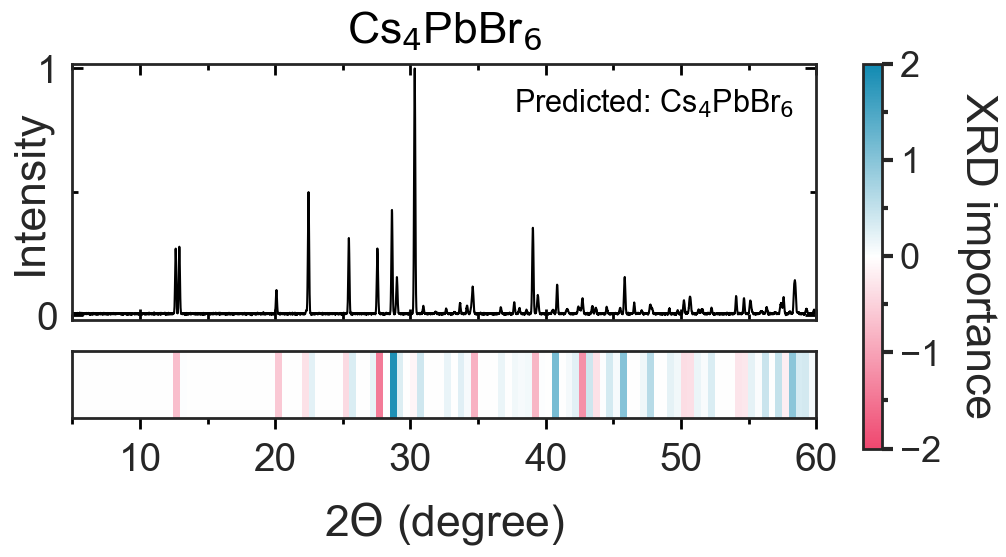

In [6]:
load_plt_setting()

prompt_type = 'full'
mymap = colors.LinearSegmentedColormap.from_list("", ["#EF476F","#FFFFFF","#118AB2"])

for j in [16]:
    i = np.where(Ys[:,j]==1)[0][0]
    
    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    if prompt_type == None:
        X_prompts.append('')
    elif prompt_type == 'eds':
        X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
    elif prompt_type == 'full':
        X_prompts.append(' '.join(element_list[i]))
    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )
    
    outputs = model(**inputs.to('cuda'), output_attentions=True)
    logits = outputs.logits
    
    y_pred = np.array(logits.argmax(-1).detach().cpu())[0]
    
    answer_idx = torch.from_numpy(np.array(Ys_int[i:i+1])).to(dtype=torch.long)

    XRD_input = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    text_input = tokenizer(X_prompts, return_tensors="pt", padding=True)['input_ids']
    baseline_XRD_input = torch.from_numpy(np.zeros(Xs_test.shape)).to(dtype=torch.float32)
    baseline_text_input = tokenizer(X_prompts, return_tensors="pt", padding=True)['input_ids']
    baseline_text_input[:,1:-1] = 0

    attributions, delta = lig.attribute(inputs=(XRD_input,text_input),baselines=(baseline_XRD_input,baseline_text_input),
                                        target=answer_idx.to('cuda'),
                                        return_convergence_delta=True)
    print('PhaseID: {}\tTarget: {}\tPredicted: {}'.format(j,formula_list[i][0],dataloader.dataset[dataloader.sample_list[y_pred]]['formula']))
    print('XRD contribution:\t\t{}'.format(attributions[0][0,text_input.shape[1]:,:].sum().item()))
    print('Elemental prior contribution:\t{}'.format(attributions[0][0,:text_input.shape[1],:].sum().item()))
    print()
    
    ##############################

    twotheta = np.arange(5.00, 60.01, 0.01)[:-1]

    XRD_contribution = np.expand_dims(np.array(attributions[0][0,text_input.shape[1]:,:].sum(dim=1).cpu().detach()),axis=0)
    XRD_contribution_norm = XRD_contribution/np.max(XRD_contribution)

    fig, (ax0, ax1) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[2, 1]),figsize=(12, 5))

    ax0.plot(twotheta, Xs[i,:-1,0], c='black')

    ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax0.axes.set_xlim([4.99,60])
    ax0.axes.set_ylim([-0.02,1.02])
    ax0.set_ylabel(f'Intensity', labelpad=-10, fontsize=32)


    extent = [twotheta[0],twotheta[-1],0,5,]
    
    mat = ax1.matshow(XRD_contribution,cmap=mymap,vmin=-np.max(XRD_contribution).round(),vmax=np.max(XRD_contribution).round(),extent=extent)
    ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
    ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
    ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax1.tick_params(axis='x',direction='out',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.tick_params(axis='x',which='minor',direction='out',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    ax1.get_yaxis().set_ticks([])
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=15, fontsize=32)

    plt.subplots_adjust(hspace=-0)

    cbar = fig.colorbar(mat, ax=[ax0, ax1])
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=26)
    cbar.ax.set_ylabel('XRD importance',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    text = re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', formula_list[i][0])
    text_split = text.split('-')
    if text_split[0] in translate_dic:
        text = translate_dic[text_split[0]] + '-' + text_split[1]

    plt.text(0.5, 1.08, text, fontsize=32, transform=ax0.transAxes, color='#000000', horizontalalignment='center')
    
    text = re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', dataloader.dataset[dataloader.sample_list[y_pred]]['formula'])
    text_split = text.split('-')
    if text_split[0] in translate_dic:
        text = translate_dic[text_split[0]] + '-' + text_split[1]
    plt.text(0.97, 0.81, 'Predicted: '+text, fontsize=22, transform=ax0.transAxes, color='#000000', horizontalalignment='right')


In [7]:
with open(os.path.join(cif_folder, 'test_dataset_1phase_orientation.npy'), 'rb') as handle:
    test_dataset = joblib.load(handle)
Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
Ys_int = [np.where(x==1)[0][0] for x in Ys]

result_dic = {}
for i in range(Ys.shape[1]):
    result_dic['{}'.format(i)] = {'label':dataloader.dataset[dataloader.sample_list[i]]['formula'],
                                  'XRD contrib':[],'Elemental contrib':[]}

prompt_type = 'full'

for i in range(Xs.shape[0]):
    
    Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

    X_prompts = []
    random.shuffle(element_list[i])
    if prompt_type == None:
        X_prompts.append('')
    elif prompt_type == 'eds':
        X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
    elif prompt_type == 'full':
        X_prompts.append(' '.join(element_list[i]))

    visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )
    
    outputs = model(**inputs.to('cuda'), output_attentions=True)
    logits = outputs.logits
    
    y_pred = np.array(logits.argmax(-1).detach().cpu())[0]
    
    answer_idx = torch.from_numpy(np.array(Ys_int[i:i+1])).to(dtype=torch.long)

    XRD_input = torch.from_numpy(Xs_test).to(dtype=torch.float32)
    text_input = tokenizer(X_prompts, return_tensors="pt", padding=True)['input_ids']
    baseline_XRD_input = torch.from_numpy(np.zeros(Xs_test.shape)).to(dtype=torch.float32)
    baseline_text_input = tokenizer(X_prompts, return_tensors="pt", padding=True)['input_ids']
    baseline_text_input[:,1:-1] = 0

    attributions, delta = lig.attribute(inputs=(XRD_input,text_input),baselines=(baseline_XRD_input,baseline_text_input),
                                        target=answer_idx.to('cuda'),
                                        return_convergence_delta=True)
    
    result_dic['{}'.format(y_pred)]['XRD contrib'].append(attributions[0][0,text_input.shape[1]:,:].sum().item())
    result_dic['{}'.format(y_pred)]['Elemental contrib'].append(attributions[0][0,:text_input.shape[1],:].sum().item())

    print('{}\t{}\t{}\t{}'.format(i,formula_list[i][0],result_dic['{}'.format(y_pred)]['XRD contrib'][-1],
                    result_dic['{}'.format(y_pred)]['Elemental contrib'][-1]))

0	CsPb(I0.2Cl0.8)3	3.7652483002081345	9.918487725167079
1	orthorhombic-CsPbBr3	4.236295862347716	0.8988913825090004
2	CsPb(Cl0.6Br0.4)3	5.156633435221051	0.3368031281165138
3	CsPb(Cl0.4Br0.6)3	2.8923944457984705	2.2426485290884974
4	CsPb(I0.2Cl0.8)3	4.89686057084089	8.896157919797963
5	alpha-FAPbI3	1.4981598268621346	12.270370944391662
6	CsPb(I0.6Cl0.4)3	4.401086221014732	11.070134035916464
7	CsPb(I0.6Br0.4)3	4.618218052632761	11.527654979033363
8	MA0.6FA0.4PbI3	4.778498557578162	9.910380273647275
9	MA0.4FA0.6PbBr3	0.449412187302654	9.648957074697071
10	MA0.2FA0.8PbBr3	2.3506566179482244	11.228356094057915
11	tetragonal-MAPbI3	-1.0683903058518858	16.94808211056388
12	CsPb(I0.6Br0.4)3	5.055750543489156	11.1331382336247
13	CsPb(I0.8Cl0.2)3	1.4555854878059207	10.756628844300813
14	Cs0.2FA0.8PbI3	-1.598302267500352	10.942197680795303
15	MA0.6FA0.4PbI3	3.2459166623921556	11.274728978913814
16	Cs0.6FA0.4PbBr3	3.9943825403642723	12.17799808805557
17	Cs0.2FA0.8PbBr3	2.575267066771029	7.9454509

148	Cs0.6MA0.4PbBr3	5.050710528057048	7.197014901506933
149	MAPb(Br0.8I0.2)3	2.760533402206689	12.720579112534047
150	alpha-MAPbI3	-0.0014404654773208514	13.87087173903618
151	cubic-FAPbBr3	-1.649884106022891	17.347320500597334
152	Pnma-MAPbCl3	18.82151258839528	13.677734031570882
153	Cs0.8MA0.2PbI3	2.406943155252793	7.6020642383568315
154	CsPb(I0.2Cl0.8)3	4.091404044850551	7.0028929052942495
155	MA0.4FA0.6PbI3	3.767382183825038	10.440311998173858
156	CsI	4.521115778503067	18.43424276155953
157	Cs0.2MA0.8PbBr3	5.815440275941015	7.6465230934828625
158	Cs0.6MA0.4PbBr3	3.4413502618433505	8.96513373618038
159	Pnma-CsPbCl3	2.057138205008626	8.765255132178156
160	PbI2	-0.5036724880429273	20.905447172558688
161	cubic-MAPbBr3	8.66631861881528	6.087990479004024
162	cubic-CsPbCl3	5.027086475091089	3.9330664405530835
163	MA0.4FA0.6PbBr3	5.01428121079429	4.941775187525132
164	cubic-CsPbCl3	0.6707463574911385	7.287481864559528
165	CsPb(Cl0.8Br0.2)3	3.199522926868027	0.48567300827292986
166	Cs0.2MA0

297	MA0.6FA0.4PbI3	4.186043355355689	10.739635963261309
298	CsPb(Cl0.2Br0.8)3	3.0336180829391877	-0.8628805156952588
299	CsBr	3.8258529459000163	1.4978167021438176
300	gamma-CsPbI3	1.1246410198373609	10.337487172405208
301	Cs0.8MA0.2PbBr3	3.8017751285339934	9.590973263593462
302	CsI	6.323688968688332	14.489440091390993
303	FAPb(Br0.4I0.6)3	7.521745974342441	8.039697241097562
304	MA0.8FA0.2PbI3	5.250867807846147	7.2375933914451505
305	Cs0.2MA0.8PbI3	3.8545056743247814	7.823290903312319
306	Cs0.4MA0.6PbI3	2.446110610623738	9.07540605595998
307	Cs4PbBr6	4.4380807871882	1.2563940492995795
308	cubic-CsPbBr3	0.536605545723622	0.4799840926876473
309	Cs0.8MA0.2PbI3	2.6512227818743557	10.191849312686582
310	CsPb(Cl0.4Br0.6)3	3.8514280212815226	2.336416212800183
311	beta-FAPbI3	-0.5848398033305082	14.35746667314922
312	MAPb(Br0.8I0.2)3	0.6292734558861874	15.273098920822363
313	Cs0.4FA0.6PbBr3	4.031729218522764	8.023661569643483
314	CsPb(Cl0.4Br0.6)3	5.459494237267997	0.22910712835660513
315	orth

445	Cs0.4FA0.6PbBr3	0.503896529033858	12.799347666576981
446	cubic-CsPbBr3	6.599754071895839	-0.3752511521169554
447	Cs0.8MA0.2PbI3	1.969405117491108	10.52363771364599
448	Cs4PbBr6	4.934198145896169	1.6574539942808288
449	alpha-MAPbI3	0.9826009154240529	15.157482649575936
450	Cs0.2MA0.8PbBr3	6.554099925311684	8.163147983585294
451	tetragonal-MAPbI3	-0.3864385738836733	16.525587981442754
452	Cs0.6FA0.4PbI3	3.3361776233169964	11.418074700719142
453	MA0.2FA0.8PbI3	2.0072945383738796	11.968515463460319
454	MA0.8FA0.2PbI3	0.7429890313699654	9.406829091423567
455	FAPb(Br0.6I0.4)3	1.8196907174254835	11.74265031664766
456	delta-FAPbI3	0.4170380117542909	14.086542213708896
457	cubic-MAPbBr3	6.002834304541145	8.95326519047016
458	CsPb(I0.2Cl0.8)3	2.8066337402282966	8.593399483866108
459	FAPb(Br0.8I0.2)3	1.6798715389820027	11.544126439171846
460	MA0.2FA0.8PbBr3	2.4062640675756803	7.610169251595909
461	Cs0.8FA0.2PbBr3	-0.10631407652676905	8.992071430625696
462	MA0.4FA0.6PbBr3	0.7319266580044942	9.

591	CsPb(Cl0.8Br0.2)3	2.253708136867461	1.699982043547472
592	Cs0.4MA0.6PbI3	2.924134458025419	8.62923572050564
593	cubic-MAPbBr3	-1.8941480552593242	13.989378751812584
594	Cs0.2FA0.8PbBr3	-2.934265746453587	11.649469410237206
595	alpha-CsPbI3	1.4138689138832847	10.760272527344611
596	Cs0.4MA0.6PbI3	2.0606622858971377	9.015138939786363
597	cubic-FAPbBr3	1.8722576455924733	20.19930611149251
598	Cs0.8MA0.2PbBr3	3.3858104614957236	10.338294742036341
599	MA0.2FA0.8PbI3	6.243204019282401	8.376511602920946
600	delta-FAPbI3	2.8062846855763843	11.915571277609367
601	cubic-MAPbBr3	8.691153480762853	5.371598885791879
602	Cs0.8MA0.2PbBr3	1.8415094120778452	10.449403472804807
603	MAPb(Br0.6I0.4)3	1.5088317146054644	14.524162312665297
604	Cs0.6MA0.4PbBr3	4.193064768754095	7.317123321914341
605	Cs0.8FA0.2PbI3	1.54496213125794	13.540071101807712
606	Cs0.8FA0.2PbI3	6.771559235804565	9.386100008665156
607	beta-FAPbI3	3.367081909279751	10.938970405215795
608	Cs0.6MA0.4PbBr3	2.2119791866081484	9.21719549

740	CsPb(Cl0.4Br0.6)3	6.75153151128611	0.057392118201668056
741	Cs0.8FA0.2PbBr3	3.087482105325666	9.085348272772233
742	CsPb(I0.4Cl0.6)3	3.232670650589101	11.51462755574535
743	MA0.2FA0.8PbI3	2.139935183430609	11.580884171335605
744	CsPb(Cl0.6Br0.4)3	3.560630928338167	1.6339856639570443
745	CsPb(I0.8Br0.2)3	5.704109423311079	10.727310040963097
746	PbBr2	0.021504820701240324	14.818121334590616
747	Cs0.8FA0.2PbBr3	-0.791395253614812	8.141448750319691
748	cubic-CsPbBr3	5.908611579758462	0.054360305159558836
749	CsPb(I0.6Cl0.4)3	4.134566378822753	11.02212696768208
750	cubic-CsPbBr3	5.125186096096657	1.0816374911369637
751	MAPb(Br0.6I0.4)3	2.4532582480628515	13.12303325956178
752	delta-CsPbI3	-0.31660180041872665	12.200781896012485
753	delta-FAPbI3	1.0185974611848443	12.481248098421698
754	CsPb(Cl0.2Br0.8)3	1.6409109601181173	0.3143847931295385
755	orthorhombic-CsPbBr3	2.754092848396151	1.8368398010682856
756	MA0.6FA0.4PbI3	5.284883736126675	9.431510730514612
757	CsPb(Cl0.4Br0.6)3	3.0924053

886	FAPb(Br0.4I0.6)3	7.607664250644801	7.189334375368766
887	Cs0.2FA0.8PbBr3	5.112851391818605	5.478975188570128
888	alpha-FAPbI3	1.9594383496695613	12.296031225141453
889	alpha-MAPbI3	1.4391656251761662	13.987023250212507
890	Cs0.2FA0.8PbI3	1.0740481771316017	6.467175321382085
891	MAPb(Br0.2I0.8)3	0.29640927918145044	13.883778447626213
892	CsPb(I0.2Cl0.8)3	5.4598010248649365	8.736941702775749
893	CsPb(Cl0.6Br0.4)3	5.493666452706449	0.057376852080521935
894	Cs0.6MA0.4PbI3	-0.8332758196797297	9.808746003059687
895	Cs0.8MA0.2PbI3	2.9315995953380583	11.712921848970556
896	Cs0.2MA0.8PbI3	0.913369335644638	8.71115440764218
897	FAPb(Br0.8I0.2)3	2.724175024603498	10.632158813498098
898	MA0.4FA0.6PbI3	5.001617387485087	9.524247374119438
899	CsBr	5.672399138150077	2.608782813865323
900	tetragonal-MAPbBr3	4.616926954091964	9.613130297386665
901	cubic-FAPbBr3	-2.229326836793027	16.890535564535114
902	CsI	5.792511949346182	16.72123620567558
903	CsI	5.6142193221051055	19.545611614310104
904	alpha-F

1033	CsPb(I0.2Cl0.8)3	2.884194015901703	5.991326707433019
1034	Cs0.6FA0.4PbBr3	7.242012234334357	6.186992161045398
1035	Cs0.2MA0.8PbBr3	6.536357415996116	7.935631574434149
1036	CsBr	2.009356168031909	1.7567480506443132
1037	FAPb(Br0.4I0.6)3	4.354754393784628	11.155385234403468
1038	MA0.4FA0.6PbI3	1.284991983588433	9.207637433489731
1039	Cs0.6FA0.4PbI3	-0.551040427104096	15.040428578322189
1040	CsPb(I0.6Br0.4)3	4.837434768481504	11.123048203661222
1041	PbI2	0.41081261473018715	18.626548166659123
1042	beta-FAPbI3	4.076759384634249	10.240383718265743
1043	CsPb(Cl0.4Br0.6)3	6.7655955012484155	-0.12808488655327033
1044	delta-CsPbI3	8.497175859372376	9.026853749242598
1045	CsPb(Cl0.6Br0.4)3	4.943156063694834	0.24553696155961907
1046	MAPb(Br0.8I0.2)3	4.46130982438236	11.085262145401202
1047	CsPb(Cl0.6Br0.4)3	4.803192285623846	0.8577385723548838
1048	orthorhombic-CsPbBr3	4.180667008823227	0.9419653258362968
1049	CsPb(I0.8Cl0.2)3	0.6253557872901614	13.814228174358382
1050	Cs0.2FA0.8PbI3	3.89943

1179	cubic-CsPbBr3	2.057802793486964	0.8186975801709571
1180	MA0.2FA0.8PbI3	2.51022158498675	11.873873120372911
1181	beta-FAPbI3	3.361687158937344	11.106692478084096
1182	Cs4PbBr6	5.346936688429652	1.051630307443527
1183	CsPb(I0.6Cl0.4)3	3.2307627373192074	11.980324820458868
1184	Cs0.2MA0.8PbI3	0.5028100866762679	16.199305851903652
1185	Cs0.6MA0.4PbI3	0.3116093848150301	7.986707815941823
1186	delta-CsPbI3	7.121567317944919	9.082328196725502
1187	Cs0.6MA0.4PbBr3	5.03382850968708	7.568570697364985
1188	CsPb(Cl0.8Br0.2)3	3.000805385086265	1.6506426729348518
1189	CsPb(I0.8Cl0.2)3	3.8056739220813256	8.347251982258987
1190	CsPb(I0.4Br0.6)3	6.781935378370629	9.287292331463536
1191	Pnma-MAPbCl3	21.22118252823052	11.885918375745877
1192	CsPb(I0.6Br0.4)3	5.699732531823072	10.28413025532099
1193	FAPb(Br0.2I0.8)3	4.64442410758433	6.910232411928259
1194	cubic-MAPbBr3	9.651589997744255	5.273959893026472
1195	MAPb(Br0.6I0.4)3	-0.03872560282460599	15.705173662956431
1196	MA0.2FA0.8PbBr3	0.898941072685

1324	FAPb(Br0.8I0.2)3	1.7617966677137498	11.267164554434395
1325	orthorhombic-CsPbBr3	0.9127179690575905	0.5527390135039261
1326	Cs0.2MA0.8PbBr3	6.022597582672038	8.099585577043161
1327	alpha-FAPbI3	2.0616376544792168	12.985037558683597
1328	CsPb(I0.8Br0.2)3	5.178556394103556	10.166576843301458
1329	Cs0.8MA0.2PbBr3	-1.055439469049535	10.930057173906633
1330	MA0.4FA0.6PbBr3	3.8283891682741262	7.362206424466114
1331	Cs0.8FA0.2PbI3	0.8916264266582632	11.06139255920008
1332	CsPb2Br5	1.7571578722082766	1.2399003121509073
1333	Cs0.8FA0.2PbBr3	1.5172578932709126	10.887886620868372
1334	FAPb(Br0.6I0.4)3	2.1577643660039754	10.538238362641737
1335	FAPb(Br0.8I0.2)3	0.5654840893990214	13.86477898607297
1336	Cs0.4MA0.6PbBr3	7.2250463289947895	4.576262359209115
1337	delta-FAPbI3	4.067756068139358	10.400931350386209
1338	MA0.8FA0.2PbBr3	4.516879557923908	8.54037308108947
1339	Cs0.4MA0.6PbBr3	3.4974762197486613	9.331901521792464
1340	MA0.2FA0.8PbBr3	-0.7570187662825344	14.058541538903965
1341	Cs0.8MA0

1469	Cs0.2MA0.8PbBr3	2.5138541719020013	11.315922304483687
1470	Cs0.4FA0.6PbI3	4.230155819007427	7.7262385264021365
1471	MA0.2FA0.8PbBr3	3.0901629813724716	9.177542120805885
1472	MAPb(Br0.4I0.6)3	2.188926115765818	17.946046685334526
1473	CsPb(I0.4Br0.6)3	7.555516764729482	7.725970519064109
1474	Cs0.4FA0.6PbBr3	7.769250205535401	4.26536035171091
1475	Cs0.6MA0.4PbI3	1.1307629942066213	10.360683894929947
1476	CsPb2Br5	3.649732595049457	1.0408326792604101
1477	MA0.6FA0.4PbBr3	4.1403773057070605	7.4012117746013315
1478	orthorhombic-CsPbBr3	3.996604446483124	1.063206132347646
1479	MA0.4FA0.6PbI3	6.718663431442986	6.80730422943311
1480	MA0.6FA0.4PbI3	4.560806189538596	9.535654243657103
1481	Cs0.6MA0.4PbBr3	2.8909998023410077	9.463019245782617
1482	FAPb(Br0.6I0.4)3	1.27589167225484	7.7817195052165005
1483	MAPb(Br0.4I0.6)3	2.02771095628913	17.63975774342027
1484	cubic-CsPbCl3	1.809704398087993	7.90389779730511
1485	CsPb(I0.4Br0.6)3	6.595988328592545	9.086342693089419
1486	FAPb(Br0.6I0.4)3	3.539

1615	Cs0.6FA0.4PbI3	0.8023643326994366	14.459124229030973
1616	Cs0.2FA0.8PbBr3	6.783051513518272	4.929423436682181
1617	cubic-MAPbBr3	5.6215726928401075	8.749326390220062
1618	MAPb(Br0.2I0.8)3	-0.3090150776094235	14.76646653588919
1619	PbI2	0.47451477287057553	20.108253185108385
1620	CsPb(Cl0.4Br0.6)3	4.443577800717107	0.7185423444380123
1621	tetragonal-MAPbBr3	-1.5027828274356905	13.889781500342501
1622	Cs0.8MA0.2PbI3	3.2369363322925837	11.38952841918476
1623	Cs0.6MA0.4PbI3	-0.1715768133528538	10.970784850345352
1624	MA0.4FA0.6PbBr3	5.995840427672261	4.1895785145685025
1625	cubic-FAPbBr3	-0.7490442924819989	20.131133594496212
1626	CsPb2Br5	4.83627954374016	1.1733514223767356
1627	CsPb(I0.6Br0.4)3	3.9845688498076224	12.189964071477988
1628	FAPb(Br0.2I0.8)3	4.3192597220663185	7.568258821162813
1629	delta-FAPbI3	3.060367126053617	11.311425125628748
1630	MAPb(Br0.2I0.8)3	0.5906746250842017	11.230960437502752
1631	MA0.2FA0.8PbBr3	0.71016684666295	12.303174436315839
1632	FAPb(Br0.2I0.8)3	4.

1761	CsPb(I0.6Cl0.4)3	1.0656091266173937	13.302106869468593
1762	MA0.2FA0.8PbBr3	0.04089016874847129	12.262696370130726
1763	PbBr2	14.198866227006365	5.940144776124453
1764	cubic-FAPbBr3	-8.346204852579042	23.090935774340558
1765	Pnma-MAPbCl3	6.668713688078434	22.726769831071486
1766	tetragonal-MAPbBr3	1.8352744917377475	9.502137487017615
1767	cubic-CsPbBr3	2.1807628441285036	0.7295171592412778
1768	Cs0.8FA0.2PbI3	3.720895226633005	11.9443342884494
1769	FAPb(Br0.4I0.6)3	5.79254522596692	8.877534301657807
1770	delta-FAPbI3	1.701908718368307	12.532733606188481
1771	MA0.6FA0.4PbI3	6.147414123474501	9.531750371486616
1772	delta-FAPbI3	0.7909015070011826	13.23999060032883
1773	cubic-CsPbCl3	2.919856963572307	5.866541810466325
1774	Cs0.4MA0.6PbBr3	0.8575174711128923	12.284508921829826
1775	FAPb(Br0.8I0.2)3	2.6699419520186436	8.583577861171754
1776	alpha-CsPbI3	4.027434707169231	12.411635959225752
1777	MA0.2FA0.8PbBr3	-0.1286573956425071	12.807882137552376
1778	CsPb(I0.8Cl0.2)3	3.409437630380

1905	Cs0.4FA0.6PbI3	2.039994872383172	10.747401642446821
1906	tetragonal-MAPbBr3	9.669353180271822	7.010577228945852
1907	MAPb(Br0.4I0.6)3	2.4160943073169956	17.412433164301476
1908	Cs0.6FA0.4PbI3	0.5763887249748336	13.652465371661716
1909	MA0.8FA0.2PbI3	3.8716628831624806	10.336265367169887
1910	MA0.8FA0.2PbI3	8.393985189199636	5.310473939955894
1911	CsPb(I0.4Cl0.6)3	3.0895854656367128	11.231384185711768
1912	Pnma-CsPbCl3	0.9114099472884578	4.945273652473445
1913	MAPb(Br0.6I0.4)3	3.8755581592607022	12.338581203442635
1914	Cs0.4MA0.6PbI3	5.124849352976119	6.929702962184123
1915	CsI	5.813572155802385	16.090934306471347
1916	CsPb(Cl0.4Br0.6)3	6.387204433190599	0.06962008955254255
1917	alpha-MAPbI3	1.2361884179180973	12.738109919322472
1918	tetragonal-MAPbI3	-1.8903570897190702	16.833515695726142
1919	cubic-CsPbCl3	2.995737252797571	6.569621218756502
1920	FAPb(Br0.8I0.2)3	2.6477435801434113	10.220127855588133
1921	MAPb(Br0.2I0.8)3	2.9748286668585635	12.274986907192815
1922	PbBr2	-1.129021

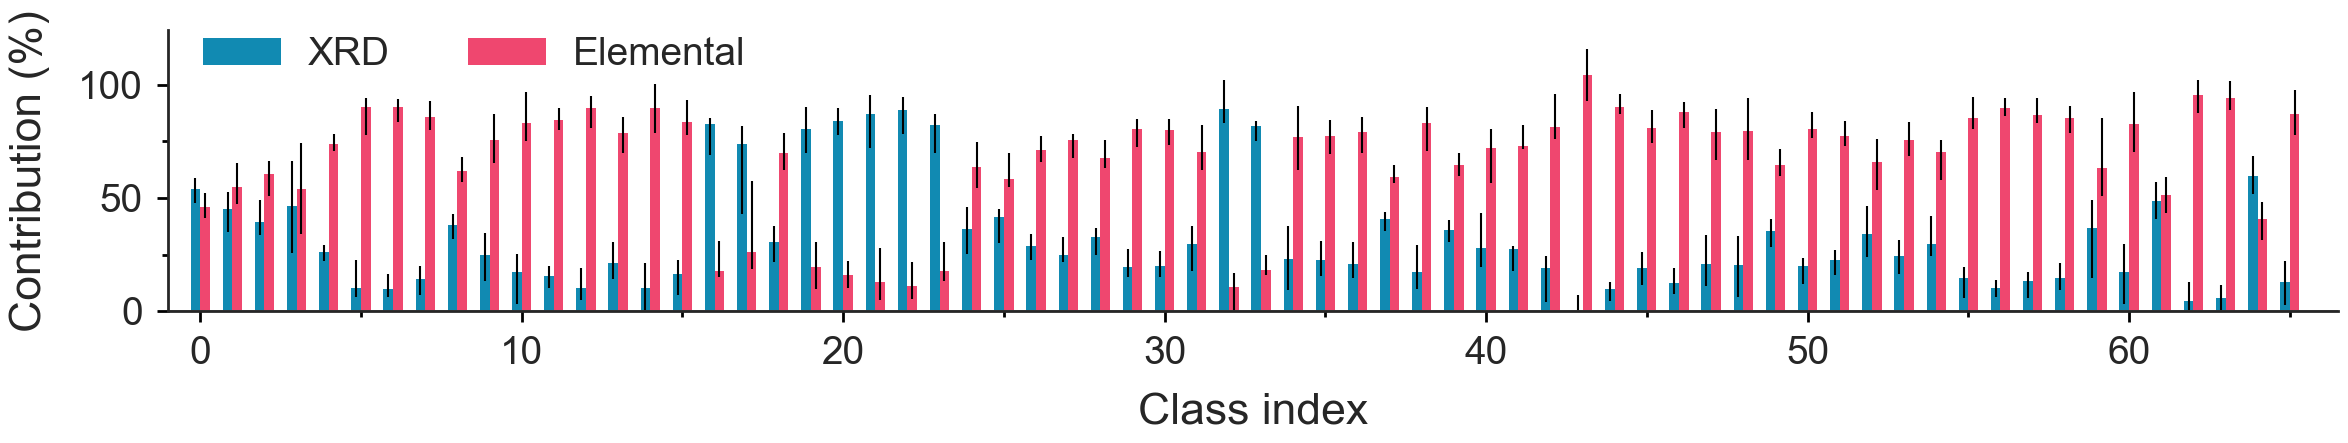

In [8]:
result_barplot = {'label':[],'XRD mean':[],'XRD error':[[],[]],'Chem mean':[],'Chem error':[[],[]],
                 'XRD mean 100':[],'XRD error 100':[[],[]],'Chem mean 100':[],'Chem error 100':[[],[]],}

for i in range(len(result_dic)):
    
    label = result_dic['{}'.format(i)]['label']
    text = re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', label)
    text_split = text.split('-')
    if text_split[0] in translate_dic:
        text = translate_dic[text_split[0]] + '-' + text_split[1]
    result_barplot['label'].append(text)

    XRD_contrib = np.array(result_dic['{}'.format(i)]['XRD contrib'])
    Chem_contrib = np.array(result_dic['{}'.format(i)]['Elemental contrib'])
    result_barplot['XRD mean'].append(np.median(XRD_contrib))
    result_barplot['XRD error'][0].append(np.median(XRD_contrib)-np.percentile(XRD_contrib,25))
    result_barplot['XRD error'][1].append(np.percentile(XRD_contrib,75)-np.median(XRD_contrib))
    result_barplot['Chem mean'].append(np.median(Chem_contrib))
    result_barplot['Chem error'][0].append(np.median(Chem_contrib)-np.percentile(Chem_contrib,25))
    result_barplot['Chem error'][1].append(np.percentile(Chem_contrib,75)-np.median(Chem_contrib))

    contrib_sum = XRD_contrib + Chem_contrib
    result_barplot['XRD mean 100'].append(np.median(XRD_contrib/contrib_sum)*100)
    result_barplot['XRD error 100'][0].append((np.median(XRD_contrib/contrib_sum)
                                               -np.percentile(XRD_contrib/contrib_sum,25))*100)
    result_barplot['XRD error 100'][1].append((np.percentile(XRD_contrib/contrib_sum,75)
                                               -np.median(XRD_contrib/contrib_sum))*100)
    result_barplot['Chem mean 100'].append(np.median(Chem_contrib/contrib_sum)*100)
    result_barplot['Chem error 100'][0].append((np.median(Chem_contrib/contrib_sum)
                                                -np.percentile(Chem_contrib/contrib_sum,25))*100)
    result_barplot['Chem error 100'][1].append((np.percentile(Chem_contrib/contrib_sum,75)
                                                -np.median(Chem_contrib/contrib_sum))*100)
    
load_plt_setting()

fig, ax = plt.subplots(figsize=(28, 3.65))

labels = []
sample_size = len(result_dic)

ax.bar(np.linspace(0,len(result_dic)-1,len(result_dic))-0.15, result_barplot['XRD mean 100'], width=0.3, 
       yerr=result_barplot['XRD error 100'],label='XRD',color=colors.to_rgba("#118AB2"))
ax.bar(np.linspace(0,len(result_dic)-1,len(result_dic))+0.15, result_barplot['Chem mean 100'], width=0.3, 
       yerr=result_barplot['Chem error 100'],label='Elemental',color=colors.to_rgba("#EF476F"))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.hlines(y=0, xmin=-1, xmax=len(result_dic)+0.5, linewidth=2, color='grey')

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=8, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=3, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

ax.axes.set_xlim([-1,len(result_dic)+0.5])
ax.axes.set_ylim([0,124])
ax.set_xlabel(r'Class index', labelpad=15, fontsize=32)
ax.set_ylabel(r'Contribution (%)', labelpad=20, fontsize=32)

plt.legend(loc="upper left", fontsize=28, handletextpad=0.7, bbox_to_anchor=(0, 1.1), ncol=2)